# AWS Lambda Request Functions

These functions should not be ran more than once - each request webscrapes 1,000 videos on default arguments. Uses default credentials from amazon CLI to run lambda functions.  

Lambda function code is provided below as well.

## Search and Log Functions

In [2]:
import boto3
import pandas as pd
import config as cfg

from pymongo import MongoClient
from youtube_transcript_api import YouTubeTranscriptApi

In [3]:
def log(content,csv):
    """
    Logs content dictionary to a csv specified by file path. If the csv file is not found, generates a new csv
    log file.
    
    """
    content_df = pd.DataFrame(content,columns=content.keys(),index=[0])
    try:
        csv_df = pd.read_csv(csv)
        csv_df = pd.concat([csv_df,content_df],ignore_index=True,sort=False)
    except:
        csv_df = content_df
        
    csv_df.to_csv(csv,index=False)

    return True

def search_and_log(query,results,recs,log_csv):
    """
    Function to call when requesting new youtube videos from aws lambda functions. Uses log function to store request
    information.
    """
    
    client = boto3.client('lambda')

    event = {
      "query": query,
      "results": results,
      "rec" : recs
    }

    response = client.invoke(
        FunctionName='vid_search',
        InvocationType='Event',
        Payload = json.dumps(event)
    )
    
    log_dict = {
        'requestID' : response['ResponseMetadata']['RequestId'],
        'query' : query,
        'max_results' : results,
        'max_rec' : recs,
        'datetime' : response['ResponseMetadata']['HTTPHeaders']['date'],
        'request_status' : response['StatusCode']
    }
    
    log(log_dict,log_csv)
    
    return response

In [4]:
#search_and_log('china hong kong',50,1,'request_log.csv')

{'ResponseMetadata': {'RequestId': '8f2c9b0c-56a5-4a3a-af78-6b8e6430b8d2',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 22 Aug 2019 18:52:19 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8f2c9b0c-56a5-4a3a-af78-6b8e6430b8d2',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-5d5ee462-8e3b895626deaf52dcc6584e;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x117e3e0b8>}

In [5]:
pd.read_csv('request_log.csv')

,requestID,query,max_results,request_status,datetime,max_rec
0,da23078c-bf88-4024-91e9-d6cc6df4353a,global warming,50,202,"Sat, 17 Aug 2019 18:25:00 GMT",NaN
1,f211c3a5-9ffc-4cd1-a700-6448aae3f589,gun rights,50,202,"Sat, 17 Aug 2019 18:25:03 GMT",NaN
2,fd4189b0-8c3b-4821-a5cc-59fee424c73e,donald trump rally,50,202,"Sat, 17 Aug 2019 18:25:49 GMT",NaN
3,f3af736f-91ea-46a6-88ff-7e44f206e5d2,abortion pro life,50,202,"Sat, 17 Aug 2019 18:26:16 GMT",NaN
4,459bdd9e-41b0-44d9-a830-68e39e343a6d,global warming,50,202,"Tue, 20 Aug 2019 20:05:45 GMT",1.0
5,cea3d2e2-aa93-40d8-9c23-008e712a18e7,mass shootings,50,202,"Tue, 20 Aug 2019 20:53:27 GMT",1.0
6,759c13a9-fe38-423b-ab49-f72da297e8f3,abortion,50,202,"Tue, 20 Aug 2019 20:53:55 GMT",1.0
7,334b3ff3-e95e-4588-a531-b39664f96384,china hong kong,50,202,"Tue, 20 Aug 2019 20:56:54 GMT",1.0
8,8f2c9b0c-56a5-4a3a-af78-6b8e6430b8d2,china hong kong,50,202,"Thu, 22 Aug 2019 18:52:19 GMT",1.0


## Update Captions

In [82]:
client = MongoClient(**cfg.config)

db = client.youtube

In [21]:
def get_all_vids(collection,filter_dict={}):
    pipeline = [
        {'$unwind': '$videos'}, 
        {'$match': filter_dict},
        {'$project': {'_id': 0, 'videoID' : '$videos.videoID'}}
    ]

    return [elem['videoID'] for elem in collection.aggregate(pipeline)]

In [27]:
def get_captions(videoID):
    captions = YouTubeTranscriptApi.get_transcript(videoID,languages=['en'])
    caption_block = " ".join([caption['text'] for caption in captions])    
    return {'videoID' : videoID,
           'caption_block' : caption_block,
           'caption_detail' : captions}

In [28]:
def update_captions(id_list,collection):
    update_list = []
    fail_list = []
    exist_list = []
    for videoID in id_list:
        if collection.count_documents({ 'videoID': videoID }, limit = 1) == 0:
            time.sleep(1)
            try:
                collection.insert_one(get_captions(videoID))
                update_list.append(videoID)
            except YouTubeTranscriptApi.CouldNotRetrieveTranscript:
                fail_list.append(videoID)
                print(f'Failed to retreive {videoID}')
        else:
            exist_list.append(videoID)
            
    return fail_list, exist_list, update_list

In [35]:
def replace_captions(id_list,collection):
    update_list = []
    fail_list = []
    for videoID in id_list:
        try:
            collection.update_one({'videoID' : videoID},{'$set' : get_captions(videoID)},upsert=True)
            update_list.append(videoID)
        except YouTubeTranscriptApi.CouldNotRetrieveTranscript:
            fail_list.append(videoID)
            print(f'Failed to retreive {videoID}')

            
    return fail_list, update_list

In [36]:
#update_captions(set(get_all_vids(db.recommendations)),db.captions)

In [48]:
#replace_captions(set(get_all_vids(db.recommendations)),db.captions)

Failed to retreive o1gaaYcoSUE
Failed to retreive q52llllXIzI
Failed to retreive Ki1F8Awrg8g
Failed to retreive 3iTALK_vf4Q
Failed to retreive 4c8eSr7x7AA
Failed to retreive hDXb6wZdpHo
Failed to retreive -6-HHQBTggc
Failed to retreive lux6fThkSW4
Failed to retreive Tc4v0dVe5_8
Failed to retreive Jnuhhz--zHo
Failed to retreive qT2sN7Oe7JA
Failed to retreive w-IHJbzRVVU
Failed to retreive yMjIBtQAzYQ
Failed to retreive GVc8cENFu9o
Failed to retreive rfq0Yw2sMq0
Failed to retreive rjqUi1By--k
Failed to retreive MSEJ0xoenFA
Failed to retreive ttXid_Fyzvo
Failed to retreive kxgeevlRElw
Failed to retreive 6ssJD4mfYBU
Failed to retreive DJIH6wzkJ44
Failed to retreive ihL9C_6TcbM
Failed to retreive nm9JWPAMh-U
Failed to retreive xG_YtASz7gY
Failed to retreive 14vqmuVm7FA
Failed to retreive Uztf1el3JUo
Failed to retreive mS4-65vgW0o
Failed to retreive 3J5ZoPFhSGM
Failed to retreive 4xTyPWjvIzM
Failed to retreive atnSg-OZ6No
Failed to retreive MFeyvS3Ze7E
Failed to retreive df3nptBrf1c
Failed t

Failed to retreive SftMxYEF5u8
Failed to retreive CA8H6ytPEmY
Failed to retreive zJuzyCY7rxw
Failed to retreive nhxvrM0N3-8
Failed to retreive fjdlJBSp1lc
Failed to retreive KE617CmKDQk
Failed to retreive ggywnPoNr4s
Failed to retreive TqralbiLcBg
Failed to retreive yXh0dhurguk
Failed to retreive VRh0muE2WZE
Failed to retreive YmaLee7JArE
Failed to retreive JszHrMZ7dx4
Failed to retreive HI9tov6A2DI
Failed to retreive PUWKe0lvscE
Failed to retreive LKz5ZB__daQ
Failed to retreive hbc8CMOoW9M
Failed to retreive 4PNB02izVwI
Failed to retreive z6ZNrr_Qs7o
Failed to retreive UhiABi6vw3A
Failed to retreive bOLuYxgWa0c
Failed to retreive cFGmXcXKd3s
Failed to retreive mv2vLeInGkk
Failed to retreive -wAauYjotJI
Failed to retreive VEF2Fjc4QeE
Failed to retreive w65GxvUC29k
Failed to retreive 4mXHhky-xsA
Failed to retreive tgofwEPVTOU
Failed to retreive iFu6TTzNjGY
Failed to retreive xxWUSIFhmQ4
Failed to retreive yZqdUBpHmhM
Failed to retreive mc0VUbQVbsU
Failed to retreive V092sZSK_8A
Failed t

Failed to retreive TAE8i40A5uI
Failed to retreive g_cZkAY8XiM
Failed to retreive VKxj2jPPvTI
Failed to retreive UwYSWAlAewc
Failed to retreive FkX0t958pQA
Failed to retreive SucqAsu0N4c
Failed to retreive S2DbJtFDi9Y
Failed to retreive b5eGi6irpRY
Failed to retreive urRX7pmj2lM
Failed to retreive rqzPTqph62U
Failed to retreive -IzgyM1r1y8
Failed to retreive wp6cnp1kZBY
Failed to retreive Kc6EF08cIKI
Failed to retreive GaLSRTNT5fw
Failed to retreive MuFC9aS7Rvk
Failed to retreive 36kXjJZ0mMU
Failed to retreive QHwa3xB8aIg
Failed to retreive ZuvK-od647c
Failed to retreive JEH4fNOqIjM
Failed to retreive AwwROS5Mxnw
Failed to retreive Jn7VcOU3x2g
Failed to retreive 1oLpepYSTLY
Failed to retreive biCVmdEMvyc
Failed to retreive H06osv-U0QU
Failed to retreive yjP6mTjTVxQ
Failed to retreive q_9j64NaoyE
Failed to retreive NwWGzQIA1HU
Failed to retreive Avqafc6fZwc
Failed to retreive HQLHRISTotM
Failed to retreive KfummC9nTRE
Failed to retreive ZjG65TOz2Ho
Failed to retreive h9R0JVCy578
Failed t

(['o1gaaYcoSUE',
  'q52llllXIzI',
  'Ki1F8Awrg8g',
  '3iTALK_vf4Q',
  '4c8eSr7x7AA',
  'hDXb6wZdpHo',
  '-6-HHQBTggc',
  'lux6fThkSW4',
  'Tc4v0dVe5_8',
  'Jnuhhz--zHo',
  'qT2sN7Oe7JA',
  'w-IHJbzRVVU',
  'yMjIBtQAzYQ',
  'GVc8cENFu9o',
  'rfq0Yw2sMq0',
  'rjqUi1By--k',
  'MSEJ0xoenFA',
  'ttXid_Fyzvo',
  'kxgeevlRElw',
  '6ssJD4mfYBU',
  'DJIH6wzkJ44',
  'ihL9C_6TcbM',
  'nm9JWPAMh-U',
  'xG_YtASz7gY',
  '14vqmuVm7FA',
  'Uztf1el3JUo',
  'mS4-65vgW0o',
  '3J5ZoPFhSGM',
  '4xTyPWjvIzM',
  'atnSg-OZ6No',
  'MFeyvS3Ze7E',
  'df3nptBrf1c',
  'l8mBl94HwCI',
  'zrBx3eRnKDE',
  'r-ArRDiQgwA',
  '9JQ-DCNmQdI',
  'GVobnGjKuLI',
  'yY7CauCCBS4',
  'lEtCW6LjA6g',
  '8n_Fk1nb7Ho',
  '6qEvGIj2X7c',
  'ldrXbhrCbeI',
  'ZD0DyeCU2ko',
  'PKCYFawZQLk',
  'ltNVyvK8Paw',
  'Uuv8yqAMNZ0',
  'Pwk9MX9-02c',
  'AzPU_0Inu5A',
  'x02ulGuYElY',
  'I2OHAuvoUkQ',
  'jIy0t5P0CUQ',
  'orkxfA7_i3U',
  'AqsfCuo4jmY',
  'hsciWLqg0vc',
  '3vvio4Y3QnM',
  'E6TNfcmPln0',
  'gd-YWTq4fto',
  'LQdwG1xf5dg',
  'T_WkoNxOkwg

## Data Viz

In [83]:
def get_caption_block(videoID):
    try:
        return db.captions.find_one({'videoID' : videoID},{'_id' : 0, 'caption_block' : 1})['caption_block']
    except:
        return None

def get_rec_vids(collection,filter_dict={}):
    pipeline = [
        {'$unwind': '$videos'}, 
        {'$match': filter_dict},
        {'$project': {'_id': 0, 'query' : 1,'parent' : 1, 'order' : '$videos.order', 'videoID' : '$videos.videoID',}}
    ]
    
    vid_df = pd.DataFrame(list(collection.aggregate(pipeline)))
    vid_df['caption'] = vid_df['videoID'].apply(get_caption_block)
    caption_series = vid_df['caption']
    caption_series.index = list(vid_df['videoID'])
    caption_series = caption_series.dropna().drop_duplicates()

    return vid_df, caption_series

In [84]:
viz_meta , viz_captions = get_rec_vids(db.recommendations,filter_dict={'requestID' : 'f3af736f-91ea-46a6-88ff-7e44f206e5d2'})

In [86]:
viz_df = pd.pivot_table(viz_meta,values=['caption'],index=['order'],columns='parent',aggfunc='count')
viz_df

caption                                                  \
parent -Tl_SPq5igw -W6G_ndFVMY 07rqR52dvCE 3iTALK_vf4Q 6ssJD4mfYBU   
order                                                                
1                1           1           0           0           0   
2                0           1           1           1           1   
3                1           1           0           0           1   
4                1           1           0           0           1   
5                0           1           0           0           1   
6                1           1           0           0           0   
7                1           1           1           1           1   
8                1           1           1           1           1   
9                1           1           1           1           1   
10               1           1           1           1           1   
11               1           0           0           1           1   
12               1           1           1           1           1   
13               1           1           1           1           0   
14               0           1           0           0           1   
15               0           0           1           1           1   
16               0           1           1           1           0   
17               1           1           0           1           0   
18               1           1           1           0           0   
19               1           0           1           1           1   
20               1           0           1           0           1   

                                                                    ...  \
parent 9GG52dxWKvI 9H69Kjm-vfY 9y6jGPqx0VU EfPXWeSRHa8 FuiG8gHTOBs  ...   
order                                                               ...   
1                1           1           0           1           0  ...   
2                1           1           1           1           1  ...   
3                1           1           1           1           1  ...   
4                1           1           1           1           1  ...   
5                1           0           1           1           1  ...   
6                1           1           1           1           1  ...   
7                1           1           1           1           1  ...   
8                1           0           1           1           1  ...   
9                1           0           1           1           0  ...   
10               1           0           1           1           0  ...   
11               1           0           1           1           1  ...   
12               1           0           1           1           0  ...   
13               1           0           1           1           0  ...   
14               1           0           1           1           1  ...   
15               1           0           0           1           1  ...   
16               1           0           1           1           0  ...   
17               1           0           1           1           1  ...   
18               1           0           1           1           1  ...   
19               1           0           1           1           1  ...   
20               1           0           1           1           1  ...   

                                                                    \
parent m4imBblhaUo o-2exoKwIpQ poFSQySJjME pt4id7l99UA rqzPTqph62U   
order                                                                
1                0           1           0           1           0   
2                1           1           0           1           1   
3                1           1           1           1           1   
4                1           1           1           1           1   
5                1           1           1           1           1   
6                1           1           1           1           0   
7                1           1           0  

In [87]:
viz_df['lost_parent1'] = -1
viz_df['lost_parent2'] = -1
viz_df['lost_parent3'] = -1
viz_df['lost_parent4'] = -1

viz_array = viz_df.to_numpy()

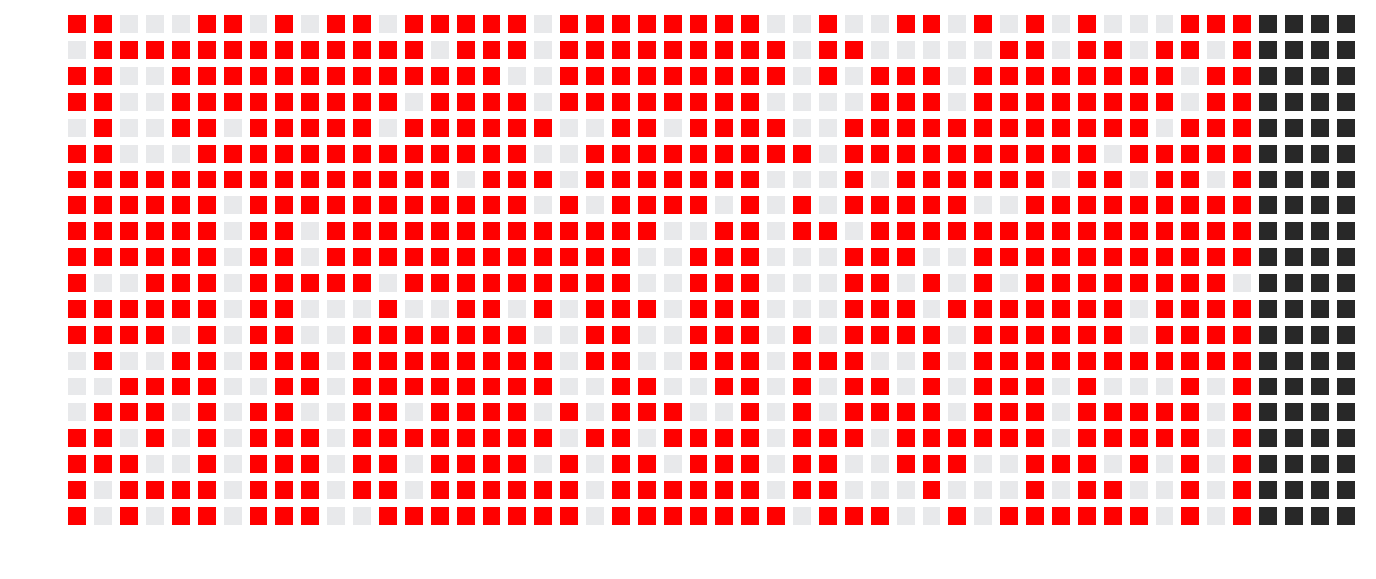

In [88]:
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

data = viz_array

rows,cols = data.shape

cmap = colors.ListedColormap(['#282828','#E8E9EB','#FF0000'])

fig, ax = plt.subplots(figsize=(30, 10))

ax.imshow(data, interpolation='nearest', 
                 extent=[0.5, 0.5+cols, 0.5, 0.5+rows],
                 cmap=cmap)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='white', linewidth=8)
ax.set_xticks(np.arange(-.5, 51, 1))
ax.set_yticks(np.arange(-.5, 21, 1))

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.show()

In [46]:
data.shape

(20, 50)

## Lambda Functions

In [4]:
#vid search function

import json
import os
import boto3
import time

from apiclient.discovery import build  
#from apiclient.discovery import build


def lambda_handler(event, context):
        
    service = build('youtube', 'v3', developerKey=os.environ['youtube_key'])

    search_response = service.search().list(
        q=event['query'],
        type="video",
        part="id",
        maxResults=event['results']
    ).execute()
    
    video_list = []
    
    client = boto3.client('lambda')

    
    for video in search_response['items']:
        event = {
            'parent' : video['id']['videoId'],
            'steps' : 20,
            'query' : event['query'],
            'tracker' : context.aws_request_id
        }
        
        client.invoke(
            FunctionName='rec_scrape',
            InvocationType='Event',
            Payload = json.dumps(event)
        )
        time.sleep(10)
        
        video_list.append(video['id']['videoId'])
        
    return {
        'statusCode': 200,
        'body': 'done!'
    }


In [5]:
#rec_scape function

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import os
import time
import json
from pymongo import MongoClient


def lambda_handler(event, context):
        
    if 'parent' in event.keys():
        parent_id = event['parent']
    else:
        return None
    if 'steps' in event.keys():
        max_steps = event['steps']
    else:
        return None
    if 'query' in event.keys():
        query = event['query']
    else:
        return None
    if 'tracker' in event.keys():
        tracker = event['tracker']
    else:
        return None

    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--window-size=1280x1696')
    chrome_options.add_argument('--user-data-dir=/tmp/user-data')
    chrome_options.add_argument('--hide-scrollbars')
    chrome_options.add_argument('--enable-logging')
    chrome_options.add_argument('--log-level=0')
    chrome_options.add_argument('--v=99')
    chrome_options.add_argument('--single-process')
    chrome_options.add_argument('--data-path=/tmp/data-path')
    chrome_options.add_argument('--ignore-certificate-errors')
    chrome_options.add_argument('--homedir=/tmp')
    chrome_options.add_argument('--disk-cache-dir=/tmp/cache-dir')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36')
    chrome_options.binary_location = "/opt/binaries/headless-chromium"

    driver = webdriver.Chrome("/opt/binaries/chromedriver",chrome_options=chrome_options)
    
    base_url = "https://www.youtube.com/watch?v="
    
    ret_dict = {'parent' : parent_id,
                'query' : query,
                'requestID' : tracker,
                '_id' : context.aws_request_id,
                'videos' : []}
    
    live_id = parent_id
    
    for i in range(0,max_steps):
        vid_step = i+1
        driver.get(base_url + live_id)
        timeout = 20
        retries = 1
        retry_max = 5
        while retries <= retry_max:
            try:
                element_present = EC.presence_of_element_located((By.XPATH , "(//*[@class='yt-simple-endpoint style-scope ytd-compact-video-renderer'])[19]"))
                WebDriverWait(driver, timeout).until(element_present)
                break
            except TimeoutException:
                if retries == retry_max:
                    raise ValueError(f'Failed to find page after {retry_max} times')
                retries += 1
                driver.refresh()
                print("Timed out waiting for page to load, retrying")

        user_data = driver.find_elements_by_xpath("//*[@class='yt-simple-endpoint style-scope ytd-compact-video-renderer']")
        
        links = []
        for i in user_data:
            links.append(i.get_attribute('href'))
            
        video_ids = [url.split('watch?v=')[-1] for url in links]
        
        vid_dict = {}
        
        vid_dict['order'] =vid_step 
        vid_dict['videoID'] = live_id
        vid_dict['recommended'] = video_ids
        
        ret_dict['videos'].append(vid_dict)
        
        live_id = video_ids[0]
    
    driver.quit()
    
    config = {
      'host': os.environ['MONGO_IP'],
      'username': os.environ['MONGO_USER'],
      'password': os.environ['MONGO_PASSWORD'],
      'authSource': 'youtube'
    }

    client = MongoClient(**config)

    db = client.youtube
    
    db.recommendations.insert_one(ret_dict)
         
    return ret_dict